This notebooks develops a discriminative model of late stage PanIN and PDAC phenotypes and identifies early activation of associated programs in K1 and K2 stages.

In [1]:
import warnings
warnings.filterwarnings("ignore") 

import os

import scutils_cnb_clean
from scutils_cnb_clean import *
np.random.seed(92771)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import entropy
from scipy.stats import gaussian_kde

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
%matplotlib inline

In [4]:
working_dir = '/Users/burdziac/Documents/PDAC/notebooks_final_June2021/'

# Hard-coded Metadata

In [5]:
#stage color coding
color_dict= {"T1 (Basal)":"#DAF7A6",
"T2":"#A1BE6C",
"T3":"#EED04D",
"T3.5":"#D4AA47",
"T4-day1":"#1D89E3",
"T4":"#1D89E3",
"T5":"#F8BADE",
"T6":"#D16BA7",
"T7_PDAC":"#BD14DA",
"T8_LiverMet":"#63009B",
"T8_PDAC_LiverMets":"#63009B",
"T8_PDAC_LungMets":"#63009B",
"T8_PDAC":"#63009B"}

#order of samples along progression
order = ['DACD351_Kate_plus', 'DACD394_Kate_plus', 'DACD406_Kate_plus',
       'DACD404_Kate_plus', 'DACD407_Kate_plus', 'DAC_DI143_Epi',
       'DACD482_Kate_plus', 'DAC_C301-EPI_1', 'DAC_C301-EPI_2',
       'Ag-PDAC-PT-Kate', 'Ag-Lung-Mets-Kate', 'DAC_D020_p5_Epi',
       'DACC963PT_Kate_plus', 'DACC963LIVERmet', 'DACC963_mKate_plus'] #K1-K6

stage_dict = {'184RH_PDAC-PT_KATE_GFP': 'T7_PDAC',
 '184RRH_LIVmet': 'T8_PDAC_LiverMets',
 'Ag-PDAC-PT-Kate': 'T7_PDAC',
 'D396_EPI': 'T3.5',
 'DAC_B528-Kate+': 'T4',
 'DAC_B530-Kate+': 'T2',
 'DAC_C263_EPI': 'T3.5',
 'DAC_C269_EPI': 'T5',
 'DAC_C301-EPI_1': 'T6',
 'DAC_C301-EPI_2': 'T6',
 'DAC_D020_p5_Epi': 'T7_PDAC',
 'DAC_DI143_Epi': 'T5',
 'DACC963_mKate_plus': 'T8_PDAC_LungMets',
 'DACC963LIVERmet': 'T8_LiverMet',
 'DACC963PT_Kate_plus': 'T7_PDAC',
 'DACD351_Kate_plus': 'T3',
 'DACD394_Kate_plus': 'T3',
 'DACD403_Kate_plus': 'T2',
 'DACD404_Kate_plus': 'T4',
 'DACD406_Kate_plus': 'T3',
 'DACD407_Kate_plus': 'T4-day1',
 'DACD482_Kate_plus': 'T5',
 'Ag-Lung-Mets-Kate': 'T8_PDAC_LungMets',
 'DACD511_Kate_plus': 'T1 (Basal)',
 'DACD550_kate_plus': 'T1 (Basal)'}

#this combines mets into one coherent stage and combines 24-48hpi samples
stage_dict_simple = {'184RH_PDAC-PT_KATE_GFP': 'T7_PDAC',
 '184RRH_LIVmet': 'T8_PDAC',
 'Ag-PDAC-PT-Kate': 'T7_PDAC',
 'D396_EPI': 'T3.5',
 'DAC_B528-Kate+': 'T4',
 'DAC_B530-Kate+': 'T2',
 'DAC_C263_EPI': 'T3.5',
 'DAC_C269_EPI': 'T5',
 'DAC_C301-EPI_1': 'T6',
 'DAC_C301-EPI_2': 'T6',
 'DAC_D020_p5_Epi': 'T7_PDAC',
 'DAC_DI143_Epi': 'T5',
 'DACC963_mKate_plus': 'T8_PDAC',
 'DACC963LIVERmet': 'T8_PDAC',
 'DACC963PT_Kate_plus': 'T7_PDAC',
 'DACD351_Kate_plus': 'T3',
 'DACD394_Kate_plus': 'T3',
 'DACD403_Kate_plus': 'T2',
 'DACD404_Kate_plus': 'T4',
 'DACD406_Kate_plus': 'T3',
 'DACD407_Kate_plus': 'T4',
 'DACD482_Kate_plus': 'T5',
 'Ag-Lung-Mets-Kate': 'T8_PDAC',
 'DACD511_Kate_plus': 'T1 (Basal)',
  'DACD550_kate_plus': 'T1 (Basal)'}

# Load Original Analysis

In [6]:
sc = load_sc(working_dir+"saved_analyses/T3-T8_EC2-AllGenes.pickle")

# PanIN/PDAC Classification

## Define Training and Validation/Application Data

In the following, we separate our dataset stored in the sc object above to late stages (upon which we will train a classification model discriminating precise stage) and early stages (upon which we apply the trained model to predict signatures of late stage disease in early cells). 

In [7]:
#getting stages for each cell
stages = np.array([stage_dict_simple[sample] for sample in sc.sample_ids])

In [8]:
#getting indices for each individual stage
injury = np.where(stages=='T4')[0]
kras = np.where(stages=='T3')[0]
early_panin = np.where(stages=='T5')[0]
late_panin = np.where(stages=='T6')[0]
pdac = np.where(np.array([stage in ['T7_PDAC','T8_PDAC'] for stage in stages]))[0]

#combining early and late stages
late_stages = np.concatenate((early_panin,late_panin,pdac))
early_stages = np.concatenate((injury,kras))

In [9]:
#defining class labels for each late stage
class_labels_dict = {"T5":0,"T6":1,'T7_PDAC':2,"T8_PDAC":3}

In [10]:
#subsetting data X and prediction labels y to late stages
X = np.log2(sc.data_normalized+.1).iloc[late_stages]
class_labels = np.array([class_labels_dict[stage] for stage in stages[late_stages]])

To ensure accuracy of the model, we split our late stage data X into training and validation sets. We will test our Logistic Regression model on the held-out validation set to ensure its accuracy.

In [11]:
#for validation, generating training and testing set
training_set = np.random.choice(range(len(late_stages)),size=int(np.ceil(len(late_stages)*.8)),replace=False)
test_set = list(set(range(len(late_stages)))-set(training_set))

In [12]:
training_set.shape

(10758,)

In [13]:
len(test_set)

2689

## Train on Late Stage Training Data

In [14]:
#training model on training data
model=LogisticRegression()
model.fit(X.iloc[training_set],class_labels[training_set])

LogisticRegression()

## Test on Late Stage Testing Data

We generate predictions from the trained model on held-out late-stage cells in the test set, and compute accuracy, precision, and recall scores. Because this is a multi-class classification approach, precision and recall are combined across classes using averaging.

In [15]:
#applying model on testing data
predictions_class_validation = model.predict(X.iloc[test_set])
predictions_validation = model.predict_proba(X.iloc[test_set])

#print some statistics
print(accuracy_score(class_labels[test_set],predictions_class_validation))
print(precision_score(class_labels[test_set],predictions_class_validation,average='macro'))
print(recall_score(class_labels[test_set],predictions_class_validation,average='macro'))

0.9966530308664932
0.9973791061398878
0.9957919915788538


To get a sense of the full predicted distribution over stages, we select a subset of cells enabling visualization of these values in a bar plot (it is prohibitive to visualize the entire test set in this way).

In [16]:
#randomly select 100 cells to visualize
ix_late = np.random.choice(predictions_validation.shape[0],size=100,replace=False)
#subset prediction probabilities to those cells
bar_data_late = pd.DataFrame(predictions_validation[ix_late,:])
#order those cells by stage in progression
order_late = np.argsort(predictions_class_validation[ix_late])
#re-order probability matrix
bar_data_late = bar_data_late.iloc[order_late]

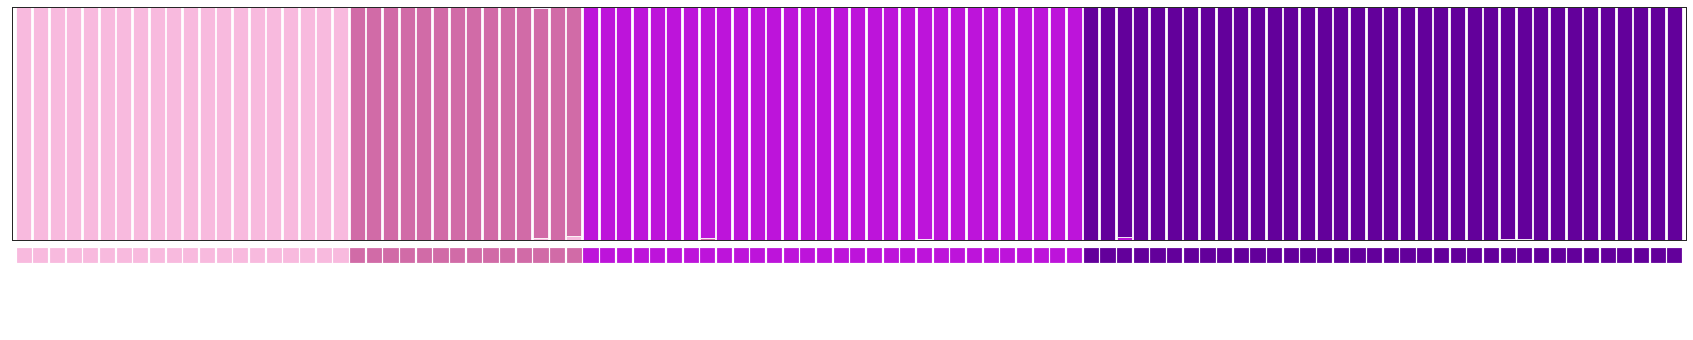

In [17]:
fig,ax=plt.subplots(2,1,figsize=(30,6),gridspec_kw={'height_ratios':(5,2)})
bar_data_late.plot(kind='bar', stacked=True,ax=ax[0],xticks=[],width=.9,yticks=[],
                    legend=False,color=[color_dict['T5'],color_dict['T6'],
                                        color_dict['T7_PDAC'],color_dict['T8_PDAC']])
ax[0].set_ylim(0,1);
xlims = ax[0].get_xlim()

axcolors = np.array([color_dict[i] for i in stages[late_stages[test_set][ix_late[order_late]]]])
ax[1].scatter(range(len(ix_late)),np.zeros(len(ix_late)),marker="s",c=axcolors,s=200)
ax[1].set_xlim(xlims)
ax[1].set_ylim(-.01,.002)
ax[1].set_axis_off()
plt.subplots_adjust(wspace=0, hspace=0)

## Predict on Early Stages

Given the accuracy of the model above, we now apply the trained model to predict labels for ealy cells.

In [18]:
#apply model to early stages
Xearly = np.log2(sc.data_normalized+.1).iloc[early_stages]
predictions = model.predict_proba(Xearly)

### Visualize Probabilities Subsetted Cells

As before, we subset 100 cells to visualize the full distribution across late stages. 

In [19]:
#randomly select 100 cells to visualize
ix = np.random.choice(predictions.shape[0],size=100,replace=False)
#subset prediction probabilities to those cells
bar_data = pd.DataFrame(predictions[ix,:])
#order those cells by stage in progression
order__ = np.argsort(bar_data[0].values)[::-1]
#re-order probability matrix
bar_data = bar_data.sort_values([0])[::-1]

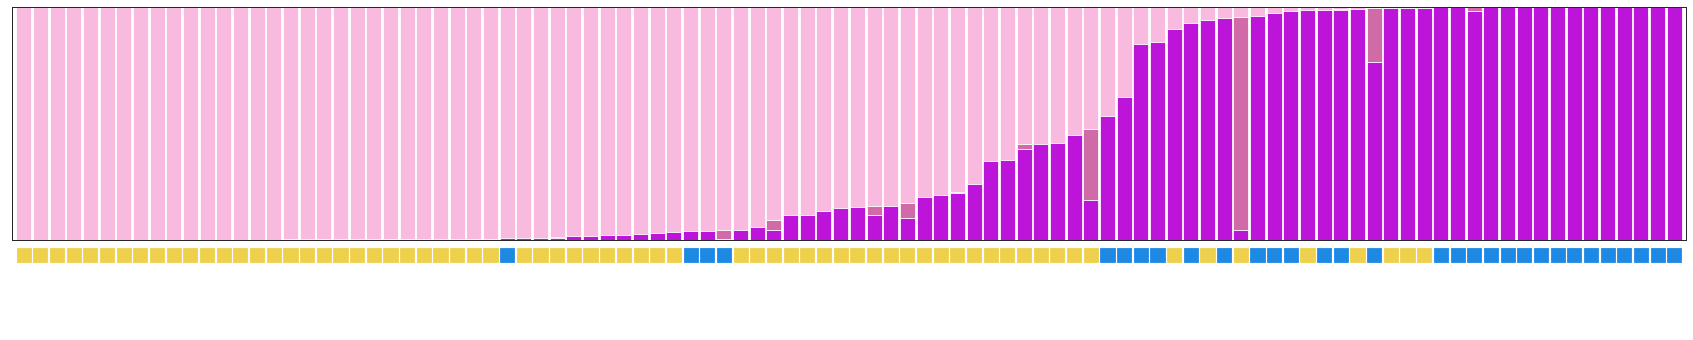

In [20]:
fig,ax=plt.subplots(2,1,figsize=(30,6),gridspec_kw={'height_ratios':(5,2)})
bar_data.plot(kind='bar', stacked=True,ax=ax[0],xticks=[],width=.9,yticks=[],
                    legend=False,color=[color_dict['T5'],color_dict['T6'],
                                        color_dict['T7_PDAC'],color_dict['T8_PDAC']])
ax[0].set_ylim(1,0);
xlims = ax[0].get_xlim()

axcolors = np.array([color_dict[i] for i in stages[early_stages[ix[order__]]]])
ax[1].scatter(range(len(ix)),np.zeros(len(ix)),marker="s",c=axcolors,s=200)
ax[1].set_xlim(xlims)
ax[1].set_ylim(-.01,.002)
ax[1].set_axis_off()
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(working_dir+"final_figures/Figure2/ProgressionCohortBen-vs-Mal_StackedBar_Jan-22-22.pdf")

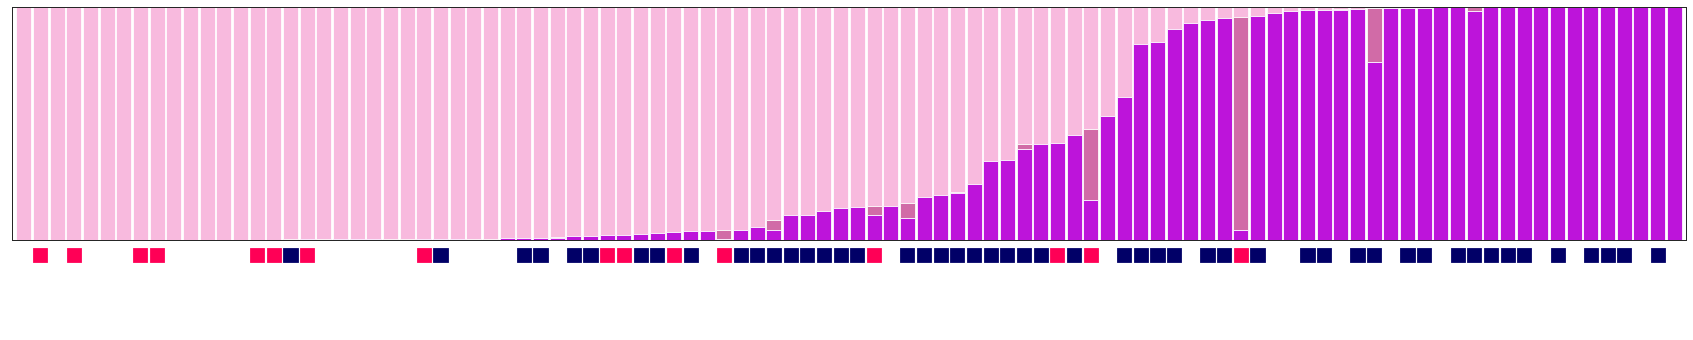

In [21]:
fig,ax=plt.subplots(2,1,figsize=(30,6),gridspec_kw={'height_ratios':(5,2)})
bar_data.plot(kind='bar', stacked=True,ax=ax[0],xticks=[],width=.9,yticks=[],
                    legend=False,color=[color_dict['T5'],color_dict['T6'],
                                        color_dict['T7_PDAC'],color_dict['T8_PDAC']])
ax[0].set_ylim(1,0);
xlims = ax[0].get_xlim()

axcolors = np.array([sc.palette[i] if i in [1,3] else "#FFFFFF" for i in sc.communities_coarse[early_stages[ix[order__]]]])
ax[1].scatter(range(len(ix)),np.zeros(len(ix)),marker="s",c=axcolors,s=200)
ax[1].set_xlim(xlims)
ax[1].set_ylim(-.01,.002)
ax[1].set_axis_off()

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(working_dir+"final_figures/Figure2/ProgressionCohortBen-vs-Mal_StackedBarClusters_Jan-22-22.pdf")

In [22]:
print(ix)

[5714  638  325 4887 1099 5761 1790 2317 1772  140 2152  121 2329 2712
 3190 6580 1342 5966  953 2428 3628 1650 4003 5950 3010 3927 2639  187
 3791 3529  363 4677 2696 5948 4189 3447 4880 5068  961 5788  319 4155
 1843  210 4797 6129 3619 5754 2717 2374  362 2689  302 1496 3797  905
 2703 2272 3857 5362  242 4626 4274 2591 2962 3554 1771 5609 2655 4751
   78 2072 2119 5672 6317  390 6099 1506 5670 5007 5652  451 2967 5392
 1141 3025 1958 6377 3715  594 3287  981 2344 4429 4512 4437 2445 6190
 4288 3941]


To get a sense of the results for the full set of early cells, we collapse predictions into benign (K3-K4) and adenocarcinoma (K5-K6) classes and visualize the complementary probability of these two classes below with a custom colormap associating with our stage color scheme.

In [23]:
#choose one visualization to use for all plots
tsne = deepcopy(sc.layout_log.values)
tsne[:,0] = tsne[:,0]*-1

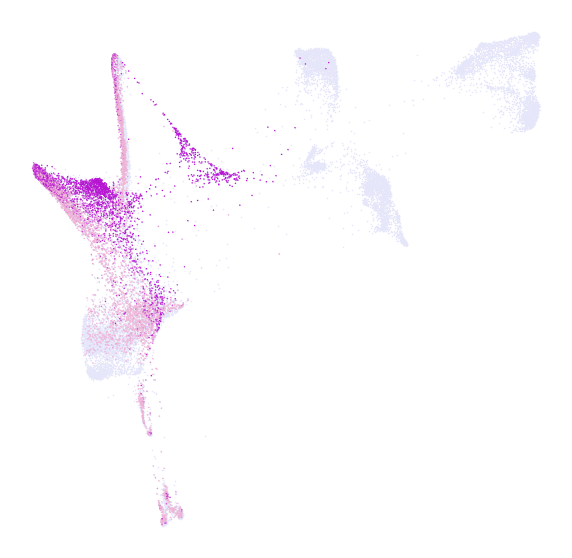

In [24]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
cmap = LinearSegmentedColormap.from_list('paninpdac', [color_dict['T5'],color_dict['T7_PDAC']], N=20)

ax.scatter(tsne[:,0],tsne[:,1],c='lavender',s=.5)
order_ = np.random.choice(early_stages.shape[0],size=early_stages.shape[0],replace=False)
ax.scatter(tsne[:,0][early_stages][order_],
           tsne[:,1][early_stages][order_],c=predictions[:,2:3].sum(1)[order_],
           s=2,cmap=cmap,linewidth=.01,edgecolor='k')
ax.set_axis_off()

plt.savefig(working_dir+"final_figures/Figure2/ProgressionCohortBen-vs-Mal_FDL_Prob_Jan-22-22.png",bbox_inches='tight')

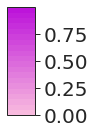

In [25]:
fig,ax = plt.subplots(figsize=(.5,2))

#adding colorbar
norm = mpl.colors.Normalize(vmin=np.min(predictions[:,2:3].sum(1)), vmax=np.max(predictions[:,2:3].sum(1)))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(20)
plt.savefig(working_dir+"final_figures/Figure2/ProgressionCohortBen-vs-Mal_FDL_Prob_Jan-22-22_cbar.pdf",bbox_inches='tight')

## Integrating ATAC Signatures

We next sought to integrate pre-computed signatures (see ... notebook) derived from bulk ATAC-seq data to evaluate whether the classification model relates to observed chromatin re-programming. We read in lists of genes from these signatures, subset to the genes observed in this dataset, and remove genes shared between the two.

In [26]:
#z-score data (standardizing each gene)
data_logged = np.log2(sc.data_normalized+.1)
data_logged_zscored = (data_logged-data_logged.mean(0).values)/data_logged.std(0).values
data_logged_zscored2 = ((data_logged.T-data_logged.mean(1).values)/data_logged.std(1).values).T

### Visualize All Probabilities

In [27]:
predictions_df = pd.DataFrame(predictions)

#sum two PanIN and two PDAC conditions to get one each value for benign and malignant
predictions_df['PanIN'] = predictions_df[[0,1]].sum(1)
predictions_df['PDAC'] = predictions_df[[2,3]].sum(1)

#sort based on PDAC probability
order_predictions = np.argsort(predictions_df['PDAC'].values)

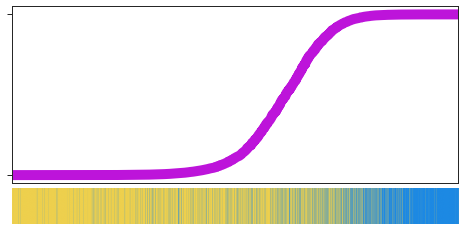

In [28]:
fig,ax=plt.subplots(2,1,figsize=(8,4),gridspec_kw={'height_ratios':(5,1)})

#axis 0: line plot
ax[0].set_ylim(-.05,1.05);
ax[0].set_xlim(0,predictions_df.shape[0]);
ax[0].plot(predictions_df['PDAC'].values[order_predictions],color=color_dict['T7_PDAC'],linewidth=10)
ax[0].set_xticks([]);
ax[0].set_yticks([0,1]);
ax[0].set_yticklabels(["",""]);


#axis 1: sample_colors
axcolors = np.array([color_dict[i] for i in stages[early_stages[order_predictions]]])
col_rgb_colors = np.asarray([matplotlib.colors.to_rgb(i) for i in axcolors])
ax[1].imshow(np.tile(col_rgb_colors[None, :, :], [1000, 1, 1]),aspect="auto")
ax[1].set_axis_off()

plt.subplots_adjust(wspace=0, hspace=.05)
plt.savefig(working_dir+"final_figures/Figure2/ProgressionCohortBen-vs-Mal_LinePlotProb_Jan-22-22.png")

### Visualizing Coefficients

In [29]:
#get coefficients for early PanIN and primary PDAC
coefficients = pd.DataFrame(model.coef_[[0,2],:],columns=list(sc.data),index=['PanIN','PDAC']).T

In [30]:
coefficients['PanIN:PDAC'] = coefficients['PanIN']-coefficients['PDAC']

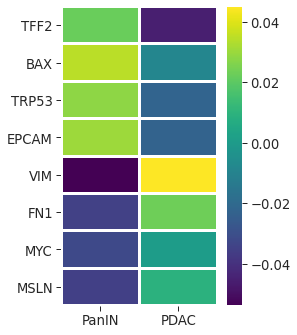

In [31]:
genes_to_plot = ['TFF2','BAX','TRP53','EPCAM','VIM',"FN1",'MYC','MSLN',]
plt.figure(figsize=(3.5,5.5))
sns.heatmap(coefficients.loc[genes_to_plot][['PanIN','PDAC']],cmap='viridis',
              linewidths=2, linecolor='white',vmax=.045)

plt.savefig(working_dir+"final_figures/Figure2/ProgressionCohortBen-vs-Mal_HeatmapCoef_Jan-22-22.pdf",bbox_inches='tight')

### Visualizing Classes (High, Low, Intermediate)

In [32]:
PDAC_prob = predictions_df['PDAC']

#define categories of low, high, and intermediate probabilities
high=early_stages[np.where(PDAC_prob>.6)[0]]
low=early_stages[np.where(PDAC_prob<.4)[0]]
intermed=early_stages[np.where((PDAC_prob>=.4)*(PDAC_prob<=.6))[0]]

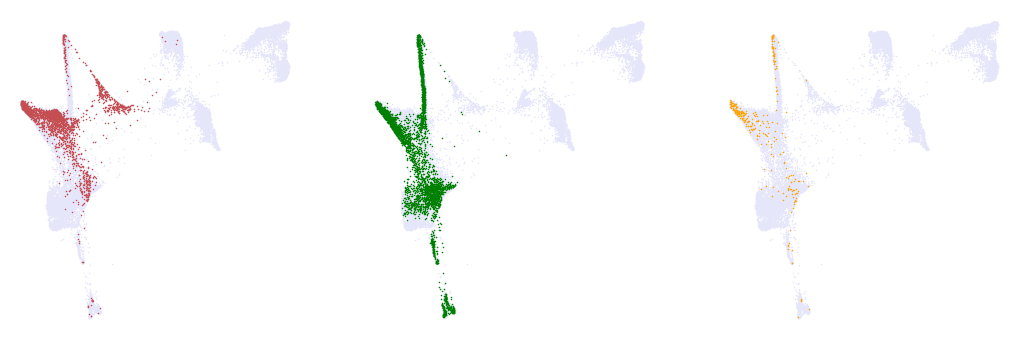

In [33]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].scatter(tsne[:,0],tsne[:,1],c='lavender',s=.5)
ax[0].scatter(tsne[:,0][high],
           tsne[:,1][high],c='r',s=.5)
ax[0].set_axis_off()

ax[1].scatter(tsne[:,0],tsne[:,1],c='lavender',s=.5)
ax[1].scatter(tsne[:,0][low],
           tsne[:,1][low],c='green',s=.5)
ax[1].set_axis_off()

ax[2].scatter(tsne[:,0],tsne[:,1],c='lavender',s=.5)
ax[2].scatter(tsne[:,0][intermed],
           tsne[:,1][intermed],c='orange',s=.5)
ax[2].set_axis_off()

In [34]:
print(len(intermed)/len(early_stages))

0.04527499240352476


#### Density

In [35]:
#fit Guassian kernel density estimate in PC space of intermediate cells
x = sc.pc_log[intermed,:][:,:sc.npca_log].T
kernel = gaussian_kde(x)

#apply to get an estimate of density for each cell to visualize cells in higher density regions
z = kernel(sc.pc_log[early_stages,:][:,:sc.npca_log].T)

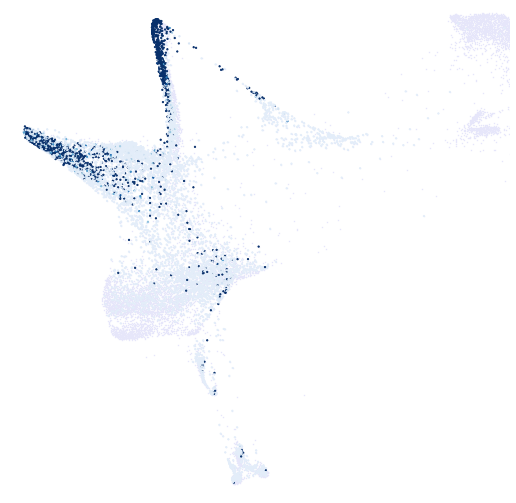

In [36]:
fig,ax=plt.subplots(figsize=(9,9))
ax.scatter(tsne[:,0],tsne[:,1],c='lavender',s=.5)

order_ = np.random.choice(early_stages.shape[0],size=early_stages.shape[0],replace=False)
ax.scatter(tsne[:,0][early_stages][order_],tsne[:,1][early_stages][order_],
           c=z[order_],cmap="Blues",vmax=np.percentile(z,80),s=2,
           vmin=np.sort(z)[5000]*-1)

ax.set_axis_off()

#copied from other notebook
xlims=(-30582.43860067619,14290.163258315315)
ylims=(-39189.39192678506, 20807.458991902786)
    
ax.set_xlim(xlims)
ax.set_ylim(ylims)

plt.savefig(working_dir+"final_figures/Figure2/ProgressionCohortBen-vs-Mal_FDLIntermedDens_Jan-22-22.png",bbox_inches='tight')

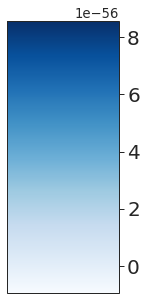

In [37]:
fig,ax = plt.subplots(figsize=(2,5))

#adding colorbar
cmap = plt.get_cmap('Blues')
norm = mpl.colors.Normalize(vmin=np.sort(z)[5000]*-1, vmax=np.percentile(z,80))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(20)
plt.savefig(working_dir+"final_figures/Figure2/ProgressionCohortBen-vs-Mal_FDLIntermedDens_Jan-22-22_bar.pdf",bbox_inches='tight')

# Enrichment of T3 in PanIN and T4 in PDAC

In [38]:
from scipy.stats import fisher_exact

In [39]:
predictions_discrete = predictions = model.predict(Xearly)

In [40]:
predictions_discrete

array([2, 2, 2, ..., 0, 0, 0])

In [41]:
#table shape
#rows: T3, T4
#columns: PanIN, PDAC

cont_table = np.zeros((2,2))
predictions_T3 = predictions_discrete[np.where(stages[early_stages]=='T3')[0]] #T3
predictions_T4 = predictions_discrete[np.where(stages[early_stages]=='T4')[0]] #T4

cont_table[0,0] = np.sum(predictions_T3==0)+np.sum(predictions_T3==1) #T3,PanIN
cont_table[0,1] = np.sum(predictions_T3==2)+np.sum(predictions_T3==3) #T3,PDAC

cont_table[1,0] = np.sum(predictions_T4==0)+np.sum(predictions_T4==1) #T4,PanIN
cont_table[1,1] = np.sum(predictions_T4==2)+np.sum(predictions_T4==3) #T4,PDAC

oddsratio, pvalue = fisher_exact(cont_table)

In [42]:
cont_table

array([[3611.,  892.],
       [ 393., 1686.]])

In [43]:
pvalue

0.0

In [44]:
oddsratio

17.36711395611543

In [45]:
cluster1_PDAC = PDAC_prob.values[np.where(sc.communities_coarse[early_stages]==1)[0]]

In [46]:
np.min(cluster1_PDAC)

1.2440369997647086e-08

In [47]:
np.max(cluster1_PDAC)

0.9999999943625718

In [48]:
coefficients.sort_values("PanIN:PDAC")[:20]

,PanIN,PDAC,PanIN:PDAC
ERDR1,-0.148929,0.066147,-0.215076
GM10076,-0.153484,0.035916,-0.189400
AY036118,-0.128298,0.050763,-0.179061
GSTP1,-0.130653,0.022188,-0.152840
MT2,-0.096982,0.047205,-0.144187
ENO1,-0.092468,0.045745,-0.138213
GM10260,-0.127739,-0.001655,-0.126084
MT1,-0.086122,0.039530,-0.125652
VIM,-0.053796,0.071487,-0.125283
GM42418,-0.100513,0.023463,-0.123976


In [49]:
coefficients.sort_values("PanIN:PDAC")[::-1][:50]

,PanIN,PDAC,PanIN:PDAC
CTRB1,0.173067,-0.084781,0.257848
PRSS2,0.136898,-0.082925,0.219823
GM10334,0.113509,-0.053412,0.166921
TRY5,0.086093,-0.064094,0.150187
PNLIPRP1,0.080804,-0.060422,0.141226
PRSS3,0.099166,-0.039812,0.138979
PYY,0.059013,-0.079500,0.138513
CPA1,0.092224,-0.040419,0.132643
H2-K1,0.073867,-0.050625,0.124492
PPY,0.045015,-0.077836,0.122851


In [50]:
coefficients.to_csv(working_dir+"final_outputs/Figure2/PanINPDACClassification_Coefficients.csv")

# Contour Plot

In [51]:
benign_genes = pd.read_csv(working_dir+"final_outputs/Figure2/Benign_Module_all.csv",header=0,index_col=0)['Benign'].values
malig_genes = pd.read_csv(working_dir+"final_outputs/Figure2/Malignant_Module_all.csv",header=0,index_col=0)['Malignant'].values

In [52]:
high2 = np.copy(pdac)
low2 = np.concatenate((early_panin,late_panin))

In [53]:
PanIN = np.array(coefficients.sort_values("PanIN")[::-1].iloc[:200].index)
PDAC = np.array(coefficients.sort_values("PDAC")[::-1].iloc[:200].index)

PanIN_unique = list(set(PanIN)-set(PDAC))
PDAC_unique = list(set(PDAC)-set(PanIN))

96 104


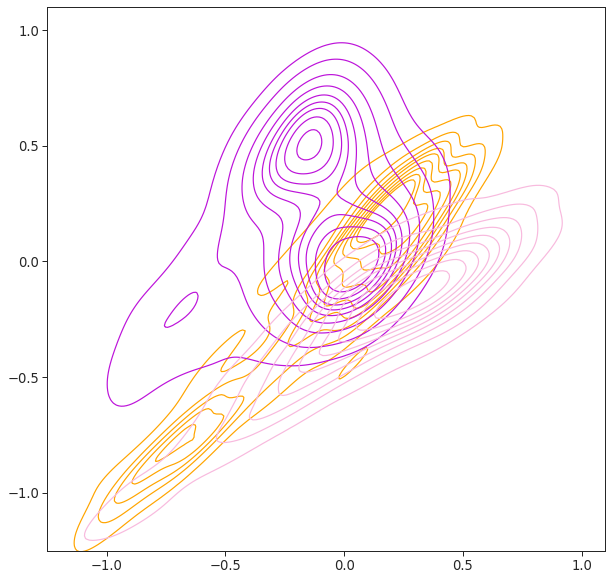

In [54]:
PanIN = np.intersect1d(PanIN,benign_genes)
PDAC = np.intersect1d(PDAC,malig_genes)
print(len(PanIN),len(PDAC))

PanINvals = data_logged_zscored[np.intersect1d(PanIN,list(data_logged))].mean(1).values
PDACvals = data_logged_zscored[np.intersect1d(PDAC,list(data_logged))].mean(1).values

fig,ax=plt.subplots(1,1,figsize=(10,10))

sns.kdeplot(PanINvals[intermed],
           PDACvals[intermed],color='orange',bw=.3)
sns.kdeplot(PanINvals[high2],
           PDACvals[high2],color=color_dict['T7_PDAC'],bw=.3)
sns.kdeplot(PanINvals[low2],
           PDACvals[low2],color=color_dict['T5'],bw=.3)
ax.set_xlim(-1.25,1.1)
ax.set_ylim(-1.25,1.1)

plt.savefig(working_dir+"final_figures/Figure2/ProgressionCohortBen-vs-Mal_Contour_Combined.pdf",bbox_inches='tight')